**Antonio Martínez Payá, 100380504**

# Homework 3: Classifying Cars & Trucks with SVMs

------------------------------------------------------
*Machine Learning, Master in Big Data Analytics, 2017-2018*

*Pablo M. Olmos olmos@tsc.uc3m.es*

------------------------------------------------------

In this homework you will work with [CIFAR-10](http://www.cs.utoronto.ca/%7Ekriz/cifar.html), a database of natural images that belong to 10 different categories.

<img src="plot_cifar.png" alt="Drawing" style="width: 500px;"/>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

In this homework, using data from a single training batch, we will classify between **cars & trucks**.  You are encouraged  to try later some other classification problems.

Lets load the libraries that we will use

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score


# use seaborn plotting defaults
import seaborn as sns; sns.set()

%matplotlib inline

C:\Users\Tono\Anaconda2\envs\TonitoPython3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Tono\Anaconda2\envs\TonitoPython3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
np.random.seed=20 

## Loading the dataset

Download the database from [here](http://www.cs.utoronto.ca/%7Ekriz/cifar-10-python.tar.gz) and unzip the file in the same folder where you are running the notebook.

Following the [instructions](http://www.cs.utoronto.ca/%7Ekriz/cifar.html), this is how you can load a batch of training data and the one for test.-

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# We use a portion of CIFAR. Batch 1 contains 10^4 image samples of 10 categories
dat = unpickle('./cifar-10-batches-py/data_batch_1')
# Test data
dat_test = unpickle('./cifar-10-batches-py/test_batch')

labels = np.array(dat[b'labels'])
images = dat[b'data']

labels_test =np.array(dat_test[b'labels'])
images_test = dat_test[b'data']

Now, we reduce the data set to only two categories. Cars (label = 1), and trucks (label = 9)

In [4]:
index_1 = 1
index_2 = 9

labels_red = labels[(labels == index_1) + (labels ==index_2)]
images_red = images[(labels == index_1) + (labels ==index_2),:]

labels_red_test = labels_test[(labels_test == index_1) + (labels_test ==index_2)]
images_red_test = images_test[(labels_test == index_1) + (labels_test ==index_2),:]

print('There are %d train images of cars and %d train images of trucks' %(np.sum(labels_red==index_1),np.sum(labels_red==index_2)))

There are 974 train images of cars and 981 train images of trucks


Lets plot some of the train images. The only tricky point is that we have to reshape the image in Red, Green, and Blue channels.

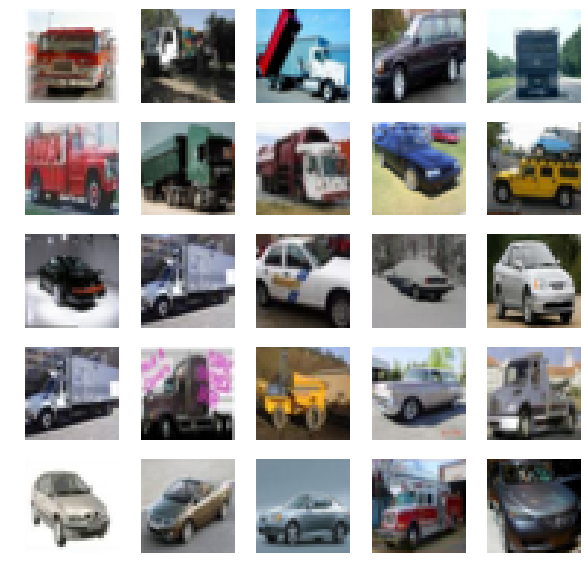

In [5]:
X = images_red.reshape(-1, 3, 32, 32).transpose(0,2,3,1)

#Visualizing CIFAR 10
fig, axes1 = plt.subplots(5,5,figsize=(10,10))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X[i:i+1][0])
        

## Data normalization

Before running the SVM, it is always desirable to normalize our training data so each feature has zero sample mean and unit variance.

** Question 1 (1 point) **

Normalize your training and test data using the training **sample mean and std**.

In [6]:
# A function that normalizes data with pre-scecified mean and std. 
def normalize(X,mu=0,std=1,flag_train=True):
    if(flag_train):
        mu = np.mean(X,0)
        std = np.std(X,0)
    
    X -= mu
    X /= std
    
    return X,mu,std


img_norm, mu, std = normalize(images_red.astype(np.float64),mu=0,std=1,flag_train=True)

img_test_norm,_,_ = normalize(images_red_test.astype(np.float64),mu,std,flag_train=False)


Note that we have used the mean and the standard deviation calculated in the training data set to normalize the test data set.

## Training a Gaussian RBF SVC

** Question 2 (3 points) ** 

* Apply a 5-times cross validation to estimate the missclasification rate varying C from .01 to 100 (in log scale) with $\gamma$ equal to 1.
* Apply a 5-times cross validation to estimate the missclasification rate varying $\gamma$ from .01 to 10 (in log scale) and the best C obtained in the previous step
* Apply a 5-times cross validation to estimate the missclasification rate varying C and $\gamma$ around the best values obtained previously in steps 2x.

On the whole train data set:
* Train a single SVC with the best C and $\gamma$
* Evaluate the missclasification rate with the trained classifier
* **Check the number of suppor vectors**

On the test data set:
* Evaluate the missclasification rate with the trained classifier
* Try to plot to missclasified images and some correctly classified

Check [here](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) to see how to use sklearn to easily obtain train/validation partitions for k-fold cross validation.

First, we are going to fix $\gamma = 0.01$, instead of $\gamma = 1$, because I have seen empirically that it works better and vary the parameter $C$ in a log scale. For this purpose, we are going to use the scikit-learn function $GridSearchCV$.

In [7]:
param_grid = {'C': [0.01,0.1,1,10,100],
              'gamma':[0.01]}

Selection1 = GridSearchCV(SVC(kernel='rbf'), 
                   param_grid,
                   scoring='accuracy',
                   cv=5 , verbose=1,n_jobs=8)

Selection1.fit(img_norm,labels_red)
print ('The best parameters are %r, giving an error of %r' %(Selection1.best_params_, 1-Selection1.best_score_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:  1.4min finished


The best parameters are {'C': 10, 'gamma': 0.01}, giving an error of 0.49411764705882355


With $\gamma = 0.01$ fixed we have obtained that the best value for $C$ is 10. Let's fix now $C=10$ and vary the value for $\gamma$.

In [9]:
param_grid = {'C': [10],
              'gamma':[0.00001,0.0001,0.001,0.01,0.1,1,10]}

Selection2 = GridSearchCV(SVC(kernel='rbf'), 
                   param_grid,
                   scoring='accuracy',
                   cv=5 , verbose=1,n_jobs=8)

Selection2.fit(img_norm,labels_red)
print ('The best parameters are %r, giving an error of %r' %(Selection2.best_params_, 1-Selection2.best_score_))

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=8)]: Done  35 out of  35 | elapsed:  1.6min finished


The best parameters are {'C': 10, 'gamma': 0.0001}, giving an error of 0.26393861892583115


Now we are going to vary these two values around them and try to find a better combination of hyperparameters:

In [11]:
param_grid = {'C': list(range(6,16,1)),
              'gamma':[0.00001,10**(-19/4),10**(-9/2),10**(-17/4),0.0001,10**(-15/4),10**(-7/2),10**(-13/4),0.001]}

Selection3 = GridSearchCV(SVC(kernel='rbf'), 
                   param_grid,
                   scoring='accuracy',
                   cv=5 , verbose=1,n_jobs=8)

Selection3.fit(img_norm,labels_red)
print ('The best parameters are %r, giving an error of %r' %(Selection3.best_params_, 1-Selection3.best_score_))

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  7.2min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 17.6min
[Parallel(n_jobs=8)]: Done 450 out of 450 | elapsed: 18.2min finished


The best parameters are {'C': 10, 'gamma': 0.00031622776601683794}, giving an error of 0.24347826086956526


With these parameters selected we train the model and compare the training error with the error obtained with CV.
We also check the number of support vectors.

In [8]:
model = SVC(kernel='rbf', C=10, gamma=0.0003162)

model.fit(img_norm, labels_red)
        
prediction_train = model.predict(img_norm)

error_train = 1 - accuracy_score(labels_red, prediction_train)

SV=len(model.support_vectors_)

#print ('The training error is %r (the error in CV is %r) and the number of support vectors is %r' %(error_train,1-Selection3.best_score_,SV))

The missclasification rate using the test is:


In [10]:
prediction_test = model.predict(img_test_norm)

error_test = 1 - accuracy_score(labels_red_test, prediction_test)

print ('The test error is %r ' %error_test)

The test error is 0.27749999999999997 


We observe that is quite larger than the test. Let's plot some missclasified images and some correctly classified:

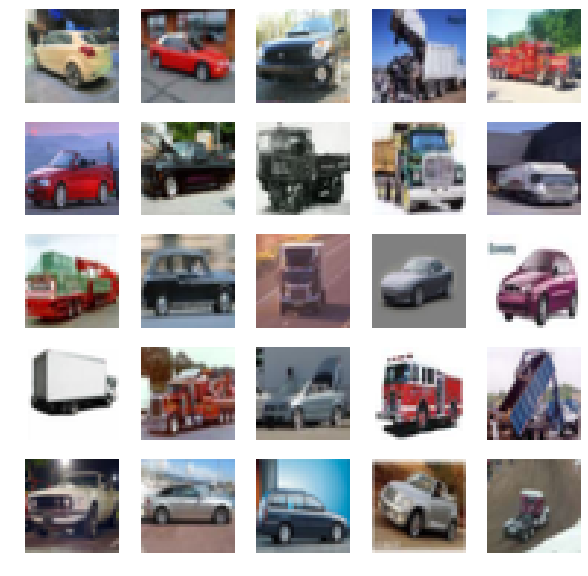

In [32]:
#Missclassified

comparation_miss = prediction_test != labels_red_test

images_red_test_miss=images_red_test[comparation_miss]

X_miss = images_red_test_miss.reshape(-1, 3, 32, 32).transpose(0,2,3,1)

fig, axes1 = plt.subplots(5,5,figsize=(10,10))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X_miss)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X_miss[i:i+1][0])
        

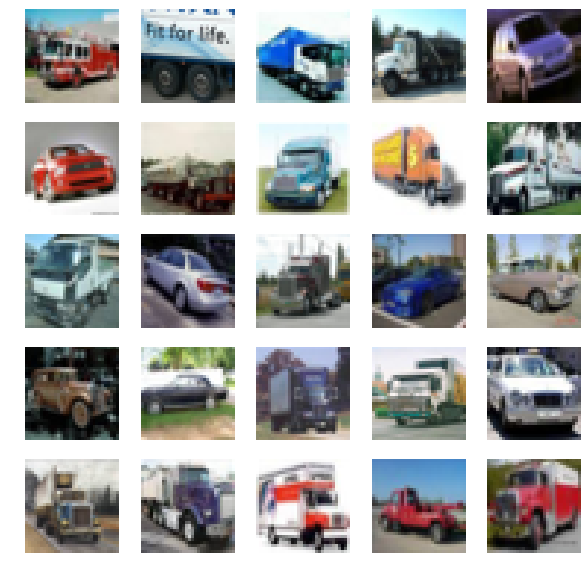

In [31]:
#Correctly clasified 

comparation_correct = prediction_test == labels_red_test

images_red_test_correct=images_red_test[comparation_correct]

X_correct = images_red_test_correct.reshape(-1, 3, 32, 32).transpose(0,2,3,1)

fig, axes1 = plt.subplots(5,5,figsize=(10,10))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X_correct)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X_correct[i:i+1][0])
        

## Training a Gaussian Polynomial SVC

** Question 3 (3 points) ** 

Set $\gamma=1$ in the polynomial kernel and then 
* Apply a 5-times cross validation to estimate the missclasification rate varying C from .01 to 100 (in log scale) with degree equal to 3.
* Apply a 5-times cross validation to estimate the missclasification rate varying degree from 1 (linear) to 5 and the best C obtained in the previous step.
* Apply a 5-times cross validation to estimate the missclasification rate using the best degree and varying C around the best value obtained previously in steps 2x.

On the whole train data set:
* Train a single SVC with the best C and degree

* Evaluate the missclasification rate with the trained classifier
* **Check the number of suppor vectors**

On the test data set:
* Evaluate the missclasification rate with the trained classifier
* Try to plot to missclasified images and some correctly classified

Check [here](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) to see how to use sklearn to easily obtain train/validation partitions for k-fold cross validation.

In [34]:
param_grid = {'C': [0.001,0.01,0.1,1,10,100],
              'degree':[3],
              'gamma':[1]}

Selection1 = GridSearchCV(SVC(kernel='poly'), 
                   param_grid,
                   scoring='accuracy',
                   cv=5 , verbose=1,n_jobs=8)

Selection1.fit(img_norm,labels_red)
print ('The best parameters are %r, giving an error of %r' %(Selection1.best_params_, 1-Selection1.best_score_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:  1.4min finished


The best parameters are {'C': 0.001, 'degree': 3, 'gamma': 1}, giving an error of 0.2951406649616368


In [36]:
param_grid = {'C': [0.001],
              'degree':[1,2,3,4,5],
              'gamma':[1]}

Selection2 = GridSearchCV(SVC(kernel='poly'), 
                   param_grid,
                   scoring='accuracy',
                   cv=5 , verbose=1,n_jobs=8)

Selection2.fit(img_norm,labels_red)
print ('The best parameters are %r, giving an error of %r' %(Selection2.best_params_, 1-Selection2.best_score_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:  1.3min finished


The best parameters are {'C': 0.001, 'degree': 3, 'gamma': 1}, giving an error of 0.2951406649616368


In [38]:
param_grid = {'C': [0.0001,(0.0001+0.001)/2,0.001,(0.001+0.01)/2,0.01],
              'degree':[2,3,4],
              'gamma':[1]}

Selection3 = GridSearchCV(SVC(kernel='poly'), 
                   param_grid,
                   scoring='accuracy',
                   cv=5 , verbose=1,n_jobs=8)

Selection3.fit(img_norm,labels_red)
print ('The best parameters are %r, giving an error of %r' %(Selection3.best_params_, 1-Selection3.best_score_))

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done  75 out of  75 | elapsed:  3.5min finished


The best parameters are {'C': 0.0001, 'degree': 3, 'gamma': 1}, giving an error of 0.2951406649616368


In [39]:
model = SVC(kernel='poly', C=0.0001, degree=3,gamma=1)

model.fit(img_norm, labels_red)
        
prediction_train = model.predict(img_norm)

error_train = 1 - accuracy_score(labels_red, prediction_train)

SV=len(model.support_vectors_)

print ('The training error is %r (the error in CV is %r) and the number of support vectors is %r' %(error_train,1-Selection3.best_score_,SV))

The training error is 0.0 (the error in CV is 0.2951406649616368) and the number of support vectors is 1636


In [40]:
prediction_test = model.predict(img_test_norm)

error_test = 1 - accuracy_score(labels_red_test, prediction_test)

print ('The test error is %r ' %error_test)

The test error is 0.28700000000000003 


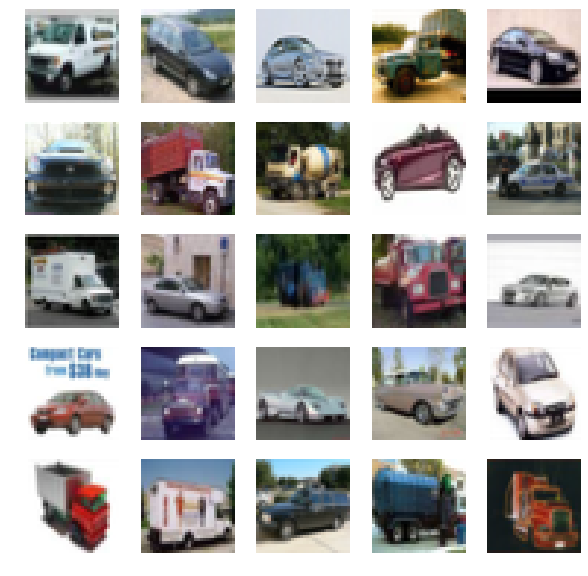

In [41]:
#Missclassified

comparation_miss = prediction_test != labels_red_test

images_red_test_miss=images_red_test[comparation_miss]

X_miss = images_red_test_miss.reshape(-1, 3, 32, 32).transpose(0,2,3,1)

fig, axes1 = plt.subplots(5,5,figsize=(10,10))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X_miss)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X_miss[i:i+1][0])
        

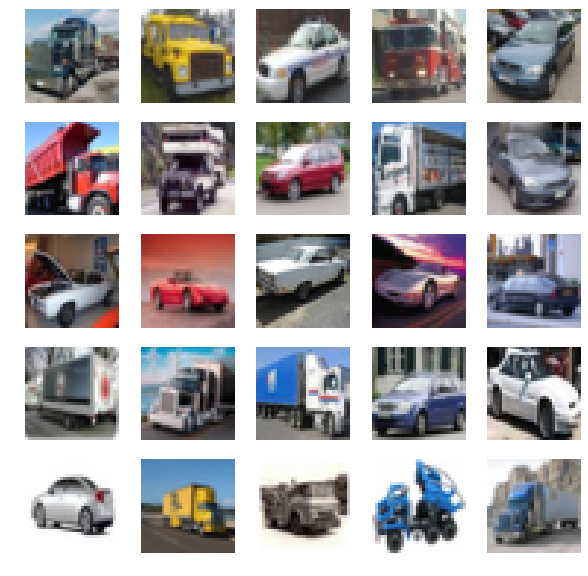

In [42]:
#Correctly clasified 

comparation_correct = prediction_test == labels_red_test

images_red_test_correct=images_red_test[comparation_correct]

X_correct = images_red_test_correct.reshape(-1, 3, 32, 32).transpose(0,2,3,1)

fig, axes1 = plt.subplots(5,5,figsize=(10,10))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X_correct)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X_correct[i:i+1][0])

## Doing some feature engineering

So far, you have essentially run your classifier without no feature engineering at all. While this may work, it is not a good idea in general.

** Question 4 (3 points) **

For each category, plot the mean of each features and try to understand if there are subsets of features (or new ones that could be created) where both categories can be separated away in a more effective way. If so, implement the SVC with the new set of features and evaluate the performance compared to the models you run before.

For instance, if we were comparing dogs & frogs, I would expect that the green levels in frog images would be higher than in dogs images.

**Note** There is no closed solution to this. I just want to make you think about your data ... 

Text(0.5,1,'Pixel Std in Train Set')

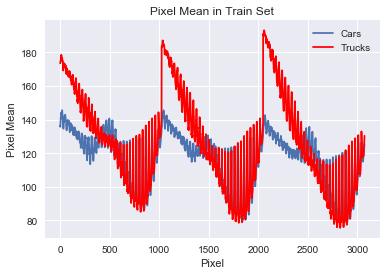

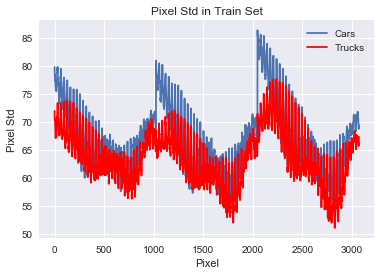

In [10]:
#The following code plots the pixel mean and std for images in each class

plt.plot(np.mean(images_red[labels_red==index_1,:],0),label='Cars')
plt.plot(np.mean(images_red[labels_red==index_2,:],0),'r',label='Trucks')
plt.legend()
plt.xlabel('Pixel')
plt.ylabel('Pixel Mean')
plt.title('Pixel Mean in Train Set')

plt.figure()
plt.plot(np.std(images_red[labels_red==index_1,:],0),label='Cars')
plt.plot(np.std(images_red[labels_red==index_2,:],0),'r',label='Trucks')
plt.legend()
plt.xlabel('Pixel')
plt.ylabel('Pixel Std')
plt.title('Pixel Std in Train Set')


We can see some tendencies in the data if we talk about the features of each class. Especially, the features in the set $[X_{1},...,X_{400},X_{1000},...,X_{1400},X_{2000},...,X_{2400}]$ (aproximately) have different mean. Also with the SD we can note some differences in some of these features. Let's do the following:

- Select the 40% of the features that have more difference in mean, because more or less is what we see on the graphs.

- Build 2 SVMs, one with RBF kernel and another one with ponlynomial kernel, both with hyperparameters around the ones obtained before.

- Compare the results.

We can select the first 100 features mentioned before:

In [146]:
mean_cars=np.mean(images_red[labels_red==index_1,:],axis=0)
print(mean_cars.shape)
mean_trucks=np.mean(images_red[labels_red==index_2,:],axis=0)
print(mean_trucks.shape)

(3072,)
(3072,)


In [147]:
vector_diff_means = abs(mean_cars-mean_trucks)
vector_diff_means.shape

(3072,)

In [149]:
A=sorted(enumerate(vector_diff_means),key = lambda x: x[1],reverse=True)[:1200]
top_index=[i for i,j in A]

new_images_red=img_norm[:,top_index]

new_images_red_test=img_test_norm[:,top_index]

In [150]:
param_grid = {'C': list(range(6,16,1)),
              'gamma':[0.00001,10**(-19/4),10**(-9/2),10**(-17/4),0.0001,10**(-15/4),10**(-7/2),10**(-13/4),0.001]}

Selection_rbf = GridSearchCV(SVC(kernel='rbf'), 
                   param_grid,
                   scoring='accuracy',
                   cv=5 , verbose=1,n_jobs=8)

Selection_rbf.fit(new_images_red,labels_red)
print ('The best parameters are %r, giving an error of %r' %(Selection_rbf.best_params_, 1-Selection_rbf.best_score_))

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   36.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  3.1min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  7.2min
[Parallel(n_jobs=8)]: Done 450 out of 450 | elapsed:  7.4min finished


The best parameters are {'C': 7, 'gamma': 0.00031622776601683794}, giving an error of 0.28132992327365725


In [155]:
model = SVC(kernel='rbf', C=7,gamma=0.00032)

model.fit(new_images_red, labels_red)
        
prediction_train = model.predict(new_images_red)

error_train = 1 - accuracy_score(labels_red, prediction_train)

SV=len(model.support_vectors_)

print ('The training error is %r (the error in CV is %r) and the number of support vectors is %r' %(error_train,1-Selection_rbf.best_score_,SV))

The training error is 0.10997442455242967 (the error in CV is 0.28132992327365725) and the number of support vectors is 1394


In [156]:
prediction_test = model.predict(new_images_red_test)

error_test = 1 - accuracy_score(labels_red_test, prediction_test)

print ('The test error is %r ' %error_test)

The test error is 0.3045 


Summaryzing, with all the atributtes we had 0.28 of error in test and now we have 0.3. Now let's do the same with the polynomial kernel.

In [158]:
param_grid = {'C': [0.0001,(0.0001+0.001)/2,0.001,(0.001+0.01)/2,0.01],
              'degree':[2,3,4],
              'gamma':[1]}

Selection_poly = GridSearchCV(SVC(kernel='poly'), 
                   param_grid,
                   scoring='accuracy',
                   cv=5 , verbose=1,n_jobs=8)

Selection_poly.fit(img_norm,labels_red)
print ('The best parameters are %r, giving an error of %r' %(Selection_poly.best_params_, 1-Selection_poly.best_score_))

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done  75 out of  75 | elapsed:  3.7min finished


The best parameters are {'C': 0.0001, 'degree': 3, 'gamma': 1}, giving an error of 0.2951406649616368


In [159]:
model = SVC(kernel='poly', C=0.0001,degree=3,gamma=1)

model.fit(new_images_red, labels_red)
        
prediction_train = model.predict(new_images_red)

error_train = 1 - accuracy_score(labels_red, prediction_train)

SV=len(model.support_vectors_)

print ('The training error is %r (the error in CV is %r) and the number of support vectors is %r' %(error_train,1-Selection_rbf.best_score_,SV))

The training error is 0.0 (the error in CV is 0.28132992327365725) and the number of support vectors is 1406


In [160]:
prediction_test = model.predict(new_images_red_test)

error_test = 1 - accuracy_score(labels_red_test, prediction_test)

print ('The test error is %r ' %error_test)

The test error is 0.364 


Nevertheless, with the polynomial kernel we obtained 0.36 of error, which is more compared to the one obtained using all the features, 0.29.

We can note also that the pixels selected are the ones from the 40% top of the image.

In conclusion, with the featuring engineering we are not able to improve the models made before.